In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/venv/3.6.9/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [3]:
from networks import IMVFullLSTM

In [35]:
import sys, importlib
importlib.reload(sys.modules['networks'])
from networks import IMVFullLSTM

import inspect as i
import sys
sys.stdout.write(i.getsource(IMVFullLSTM))

class IMVFullLSTM(torch.jit.ScriptModule):
    __constants__ = ["n_units", "input_dim"]
    def __init__(self, input_dim, output_dim, n_units, init_std=0.02):
        super().__init__()
        self.U_j = nn.Parameter(torch.randn(input_dim, 1, n_units)*init_std)
        self.W_j = nn.Parameter(torch.randn(input_dim, n_units, n_units)*init_std)
        self.b_j = nn.Parameter(torch.randn(input_dim, n_units)*init_std)
        self.W_i = nn.Linear(input_dim*(n_units+1), input_dim*n_units)
        self.W_f = nn.Linear(input_dim*(n_units+1), input_dim*n_units)
        self.W_o = nn.Linear(input_dim*(n_units+1), input_dim*n_units)
        self.F_alpha_n = nn.Parameter(torch.randn(input_dim, n_units, 1)*init_std)
        self.F_alpha_n_b = nn.Parameter(torch.randn(input_dim, 1)*init_std)
        self.F_beta = nn.Linear(2*n_units, 1)
        self.Phi = nn.Linear(2*n_units, output_dim)
        self.n_units = n_units
        self.input_dim = input_dim
    @torch.jit.script_method
    def forward

In [5]:
data1 = pd.read_csv("SML2010/NEW-DATA-1.T15.txt", sep=' ')
data2 = pd.read_csv("SML2010/NEW-DATA-2.T15.txt", sep=' ')

In [6]:
target = '3:Temperature_Comedor_Sensor'
cols = [
    '3:Temperature_Comedor_Sensor',
 '4:Temperature_Habitacion_Sensor',
 '5:Weather_Temperature',
 '6:CO2_Comedor_Sensor',
 '7:CO2_Habitacion_Sensor',
 '8:Humedad_Comedor_Sensor',
 '9:Humedad_Habitacion_Sensor',
 '10:Lighting_Comedor_Sensor',
 '11:Lighting_Habitacion_Sensor',
 '12:Precipitacion',
 '13:Meteo_Exterior_Crepusculo',
 '14:Meteo_Exterior_Viento',
 '15:Meteo_Exterior_Sol_Oest',
 '16:Meteo_Exterior_Sol_Est',
 '20:Exterior_Entalpic_2',
 '21:Exterior_Entalpic_turbo',
 '22:Temperature_Exterior_Sensor']

In [7]:
data1.head()

,#,Unnamed: 1,1:Date,2:Time,3:Temperature_Comedor_Sensor,4:Temperature_Habitacion_Sensor,5:Weather_Temperature,6:CO2_Comedor_Sensor,7:CO2_Habitacion_Sensor,8:Humedad_Comedor_Sensor,...,15:Meteo_Exterior_Sol_Oest,16:Meteo_Exterior_Sol_Est,17:Meteo_Exterior_Sol_Sud,18:Meteo_Exterior_Piranometro,19:Exterior_Entalpic_1,20:Exterior_Entalpic_2,21:Exterior_Entalpic_turbo,22:Temperature_Exterior_Sensor,23:Humedad_Exterior_Sensor,24:Day_Of_Week
0,13/03/2012,11:45,18.1875,17.8275,0.0,216.560,221.920,39.9125,42.4150,81.6650,...,95436.8,758.880,0,0,0,18.1150,48.3750,2.0,NaN,NaN
1,13/03/2012,12:00,18.4633,18.1207,6.8,219.947,220.363,39.9267,42.2453,81.7413,...,95436.8,762.069,0,0,0,18.4147,47.8080,2.0,NaN,NaN
2,13/03/2012,12:15,18.7673,18.4367,17.0,219.403,218.933,39.7720,42.2267,81.4240,...,95398.6,766.251,0,0,0,18.8533,47.4320,2.0,NaN,NaN
3,13/03/2012,12:30,19.0727,18.7513,18.0,218.613,217.045,39.7760,42.0987,81.5013,...,95360.3,766.037,0,0,0,19.2907,47.0240,2.0,NaN,NaN
4,13/03/2012,12:45,19.3721,19.0414,20.0,217.714,216.080,39.7757,42.0686,81.4657,...,95354.9,762.743,0,0,0,19.7400,45.4743,2.0,NaN,NaN


In [8]:
train_size = 3200
val_size = 400
depth = 10
batch_size = 128
prediction_horizon = 1

In [9]:
X_train1 = np.zeros((len(data1), depth, len(cols)))
y_train1 = np.zeros((len(data1), 1))

In [10]:
X_train1.shape, y_train1.shape

((2764, 10, 17), (2764, 1))

In [11]:
for i, name in enumerate(cols):
    for j in range(depth):
        X_train1[:, j, i] = data1[name].shift(depth - j - 1).fillna(method="bfill")
y_train1 = data1[target].shift(-prediction_horizon).fillna(method='ffill')

In [12]:
X_train1 = X_train1[depth:-prediction_horizon]
y_train1 = y_train1[depth:-prediction_horizon]

In [13]:
X2 = np.zeros((len(data2), depth, len(cols)))
y2 = np.zeros((len(data2), 1))

In [14]:
for i, name in enumerate(cols):
    for j in range(depth):
        X2[:, j, i] = data2[name].shift(depth - j - 1).fillna(method="bfill")
y2 = data2[target].shift(-prediction_horizon).fillna(method='ffill')

In [15]:
X_train2 = X2[:train_size - len(data1)]
y_train2 = y2[:train_size - len(data1)]

X_val = X2[train_size - len(data1):train_size - len(data1) + val_size]
y_val = y2[train_size - len(data1):train_size - len(data1) + val_size]

X_test = X2[train_size - len(data1) + val_size:]
y_test = y2[train_size - len(data1) + val_size:]

In [16]:
X_train2 = X_train2[depth:]
y_train2 = y_train2[depth:]

In [17]:
X_train = np.concatenate([X_train1, X_train2], axis=0)
y_train = np.concatenate([y_train1, y_train2], axis=0)

In [18]:
X_train.shape, y_train.shape

((3179, 10, 17), (3179,))

In [19]:
X_train_min, y_train_min = X_train.min(axis=0), y_train.min(axis=0)
X_train_max, y_train_max = X_train.max(axis=0), y_train.max(axis=0)

In [20]:
X_train = (X_train - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_val = (X_val - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_test = (X_test - X_train_min)/(X_train_max - X_train_min + 1e-9)

y_train = (y_train - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_val = (y_val - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_test = (y_test - y_train_min)/(y_train_max - y_train_min + 1e-9)


In [21]:
X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)
y_train_t = torch.Tensor(y_train)
y_val_t = torch.Tensor(y_val.values)
y_test_t = torch.Tensor(y_test.values)

In [22]:
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), shuffle=True, batch_size=batch_size)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), shuffle=False, batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), shuffle=False, batch_size=batch_size)


In [36]:
model = IMVFullLSTM(X_train.shape[2], 1, 128)
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [25]:
epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [27]:
import time

In [37]:
epochs = 1
loss = nn.MSELoss()
patience = 35
min_val_loss = 9999
counter = 0
for i in range(epochs):
    mse_train = 0
    iteration_start = time.monotonic()
    for batch_x, batch_y in train_loader :
        batch_x = batch_x
        batch_y = batch_y
        opt.zero_grad()
        y_pred, alphas, betas = model(batch_x)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
    epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in val_loader:
            batch_x = batch_x
            batch_y = batch_y
            output, alphas, betas = model(batch_x)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    if min_val_loss > mse_val**0.5:
        min_val_loss = mse_val**0.5
        print("Saving...")
        torch.save(model.state_dict(), "imv_lstm_sml2010.pt")
        counter = 0
    else: 
        counter += 1
    
    if counter == patience:
        break
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, "val: ", (mse_val/len(X_val_t))**0.5)
    iteration_end = time.monotonic()
    print("Iter time: ", iteration_end - iteration_start)
    if(i % 10 == 0):
        preds = preds*(y_train_max - y_train_min) + y_train_min
        true = true*(y_train_max - y_train_min) + y_train_min
        mse = mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("mse: ", mse, "mae: ", mae)
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()

RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
  File "/Users/long/Documents/BCI/python_scripts/googleDrive/examples/IMV_LSTM-master/networks.py", line 102, in forward
            o_t = torch.sigmoid(self.W_o(inp))
            # eq 3
            c_t = c_t*f_t + i_t*j_tilda_t.view(j_tilda_t.shape[0], -1)
                                ~~~~~~~~~~~~~~ <--- HERE
            # eq 4
            h_tilda_t = (o_t*torch.tanh(c_t)).view(h_tilda_t.shape[0], self.input_dim, self.n_units)
RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.


In [50]:
model.load_state_dict(torch.load("imv_lstm_sml2010.pt"))

<All keys matched successfully>

In [51]:
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    alphas = []
    betas = []
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        output, a, b = model(batch_x)
        output = output.squeeze(1)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        alphas.append(a.detach().cpu().numpy())
        betas.append(b.detach().cpu().numpy())
        mse_val += loss(output, batch_y).item()*batch_x.shape[0]
preds = np.concatenate(preds)
true = np.concatenate(true)
alphas = np.concatenate(alphas)
betas = np.concatenate(betas)

In [52]:
preds = preds*(y_train_max - y_train_min) + y_train_min
true = true*(y_train_max - y_train_min) + y_train_min

In [53]:
mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)

In [54]:
mse, mae

(0.29738528, 0.43004093)

In [55]:
mse**0.5

0.5453304276894166

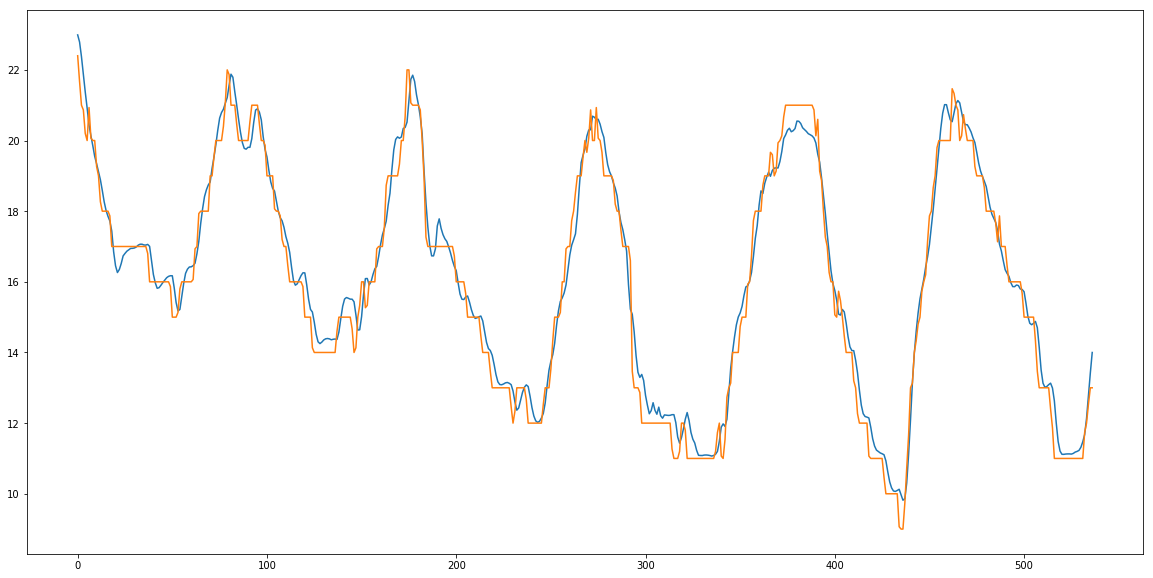

In [56]:
plt.figure(figsize=(20, 10))
plt.plot(preds)
plt.plot(true)
plt.show()

In [57]:
alphas.shape

(537, 10, 17, 1)

In [58]:
betas.shape

(537, 17, 1)

In [59]:
alphas = alphas.mean(axis=0)
betas = betas.mean(axis=0)

In [60]:
alphas = alphas[..., 0]
betas = betas[..., 0]

In [61]:
alphas = alphas.transpose(1, 0)

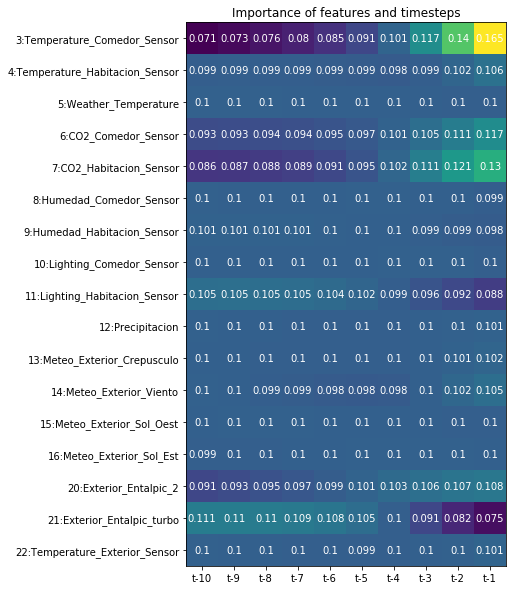

In [62]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(alphas)
ax.set_xticks(np.arange(X_train_t.shape[1]))
ax.set_yticks(np.arange(len(cols)))
ax.set_xticklabels(["t-"+str(i) for i in np.arange(X_train_t.shape[1], -1, -1)])
ax.set_yticklabels(cols)
for i in range(len(cols)):
    for j in range(X_train_t.shape[1]):
        text = ax.text(j, i, round(alphas[i, j], 3),
                       ha="center", va="center", color="w")
ax.set_title("Importance of features and timesteps")
#fig.tight_layout()
plt.show()

([<matplotlib.axis.XTick at 0x7fc1f46534e0>,
 <a list of 17 Text xticklabel objects>)

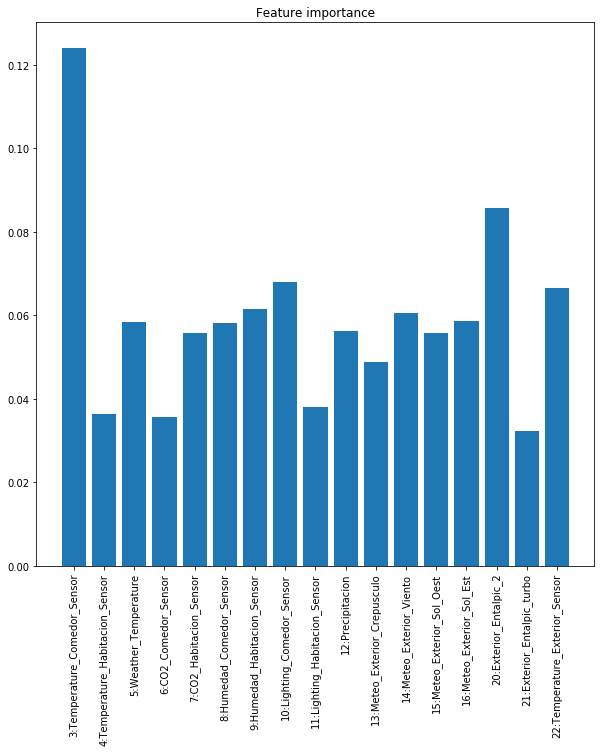

In [64]:
plt.figure(figsize=(10, 10))
plt.title("Feature importance")
plt.bar(range(len(cols)), betas)
plt.xticks(range(len(cols)), cols, rotation=90)